In [1]:
import os
import pandas as pd
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline 

labels = pd.read_csv(
    "../train.csv",
    names=['ID', 'Class']
)
train_files = glob('{}/data/Train/*.wav'.format(os.path.abspath('../')))

The goal of this notebook is to find:

1. Smallest resolution spectrogram without losing clear patterns
2. Convert spectrograms created from wavs of differing audio length into uniform shape

In [2]:
def data_to_spec(data):
    D = librosa.stft(data)
    return librosa.power_to_db(np.abs(D)**2, ref=np.median)

def file_to_spec(filename):
    data, rate = librosa.load(filename)
    return data_to_spec(data)

def file_to_label(filename):
    fname = os.path.basename(filename)
    cid = fname.replace('.wav', '')
    classname = labels.loc[labels['ID'] == cid]
    return classname.values.tolist()[0][1] 

def show_file(filename):
    plt.title(file_to_label(filename))
    librosa.display.specshow(file_to_spec(filename), x_axis='time', y_axis='linear');
    plt.colorbar(); 

-24.284554 55.715446


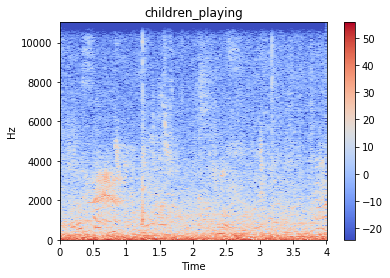

In [6]:
# Visualize full sized spectrogram

file = train_files[13]
sp = file_to_spec(file)
print(np.amin(sp), np.amax(sp))
show_file(file)                        

In [260]:
siren = file_to_spec(file)
print('spectrogram shape:', siren.shape)

spectrogram shape: (1025, 173)


### Data format is (frequency, timeslice)

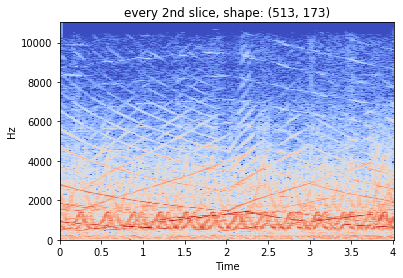

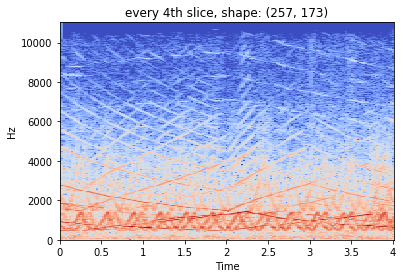

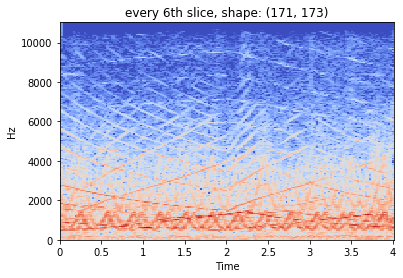

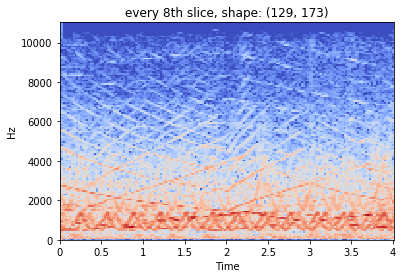

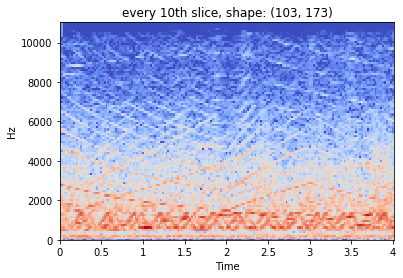

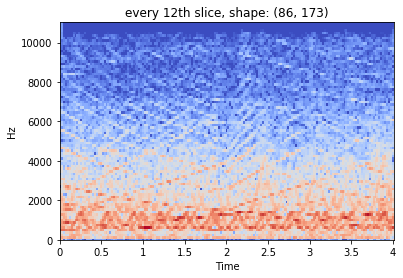

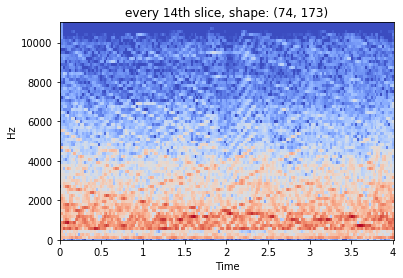

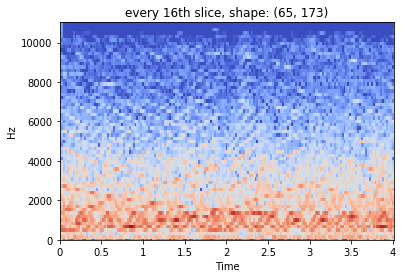

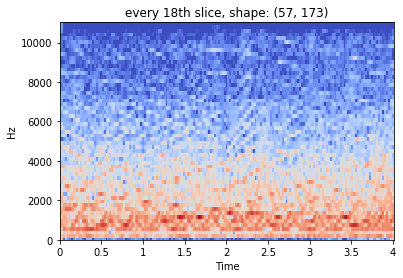

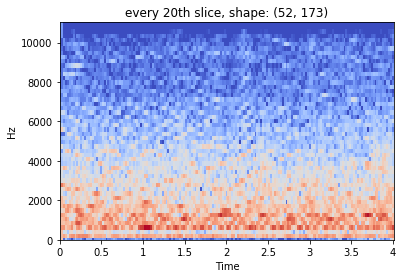

In [261]:
import humanize
#decimate frequency bands at different factors and render
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = siren[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2

In [262]:
#from scipy import stats
#stats.describe(spec[0])

Now we're going to consider a car horn sound.  It's much shorter in length, less than a 1/2 second.  All of my audio is in the range of (.4,4) seconds, or between less than a second and 4 seconds.

I would like to include short and longer sounds in my training set, but my time axis must be uniform.  This means I will either have to discard data along the time axis for the longer samples---until the length of time matches the shortest lenghted audio sample, or extend the time on the shorter spectrograms to equal the full four seconds.

Most of my audio samples are 4 seconds long, and I'd hate to throw away the patterns from the finer resolution data.  I don't think I'll be skewing too much by lengthening the short spectrograms though, so let's try that.

spec shape: (1025, 9)
audio samples: (4574,)


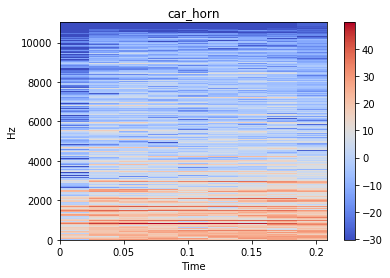

In [263]:
#information about the car horn sound
horn_file = train_files[11]
horn = file_to_spec(horn_file)
print("spec shape:", horn.shape)
print("audio samples:", librosa.load(horn_file)[0].shape)
show_file(horn_file)  

In [264]:
ipd.Audio(horn_file)

In [265]:
# At this resolution it's pretty easy to see
# the correlation between the numbers in the array and and the graph. 
horn

array([[ 17.339193  ,  14.539494  ,  30.473139  , ...,  24.315796  ,
         -8.913864  ,  14.3094845 ],
       [  0.83141994,  23.272743  ,  30.314497  , ...,  31.486227  ,
         31.259493  ,  32.028633  ],
       [ 17.145294  ,  26.245985  ,  26.080149  , ...,  36.097862  ,
         32.343338  ,  28.894356  ],
       ...,
       [-30.241455  , -30.241455  , -30.241455  , ..., -30.241455  ,
        -30.241455  , -26.04011   ],
       [-30.241455  , -30.241455  , -30.241455  , ..., -30.241455  ,
        -30.241455  , -26.039919  ],
       [-30.241455  , -30.241455  , -30.241455  , ..., -30.241455  ,
        -30.241455  , -26.08053   ]], dtype=float32)

In [266]:
horn.shape

(1025, 9)

In [267]:
from scipy import signal
print(horn[0])
#signal.resample(horn, 1025,73)


[17.339193  14.539494  30.473139  26.169077  21.603485  17.833673
 24.315796  -8.913864  14.3094845]


In [268]:
# Let's resample
upsampled_horn = signal.resample(horn, 173, axis=1)

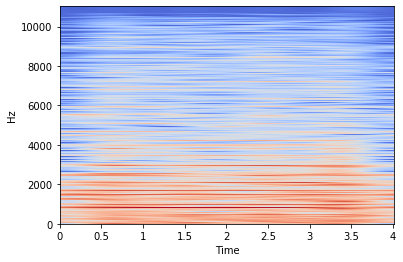

In [269]:
librosa.display.specshow(upsampled_horn, x_axis='time', y_axis='linear')

That looks nice, but will the smooth transition between time slices help or hurt when training on this data?  


Also consider 
* repeating 
* time stretching 

In [270]:
# I need a method that repeats based on the number of buckets I end up with

#horn_with_repeats = np.repeat(horn, 173, axis=1)

In [271]:
#librosa.display.specshow(horn_with_repeats, x_axis='time', y_axis='linear')

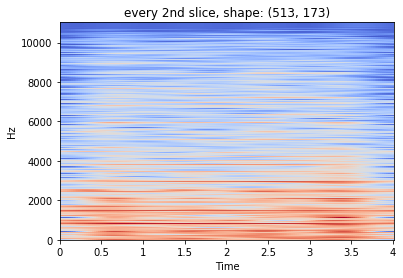

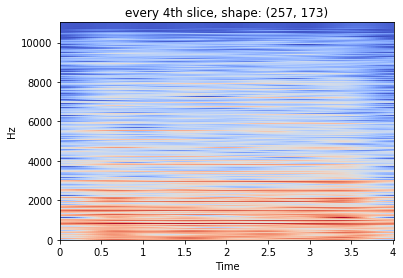

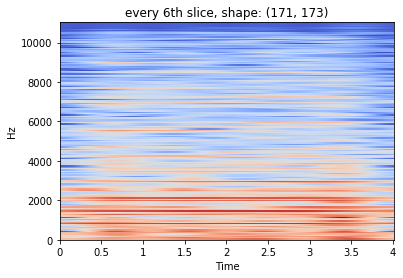

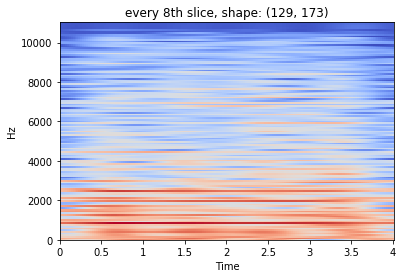

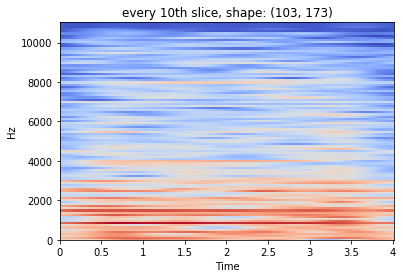

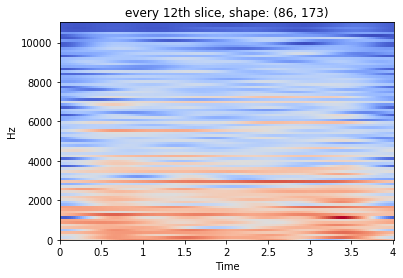

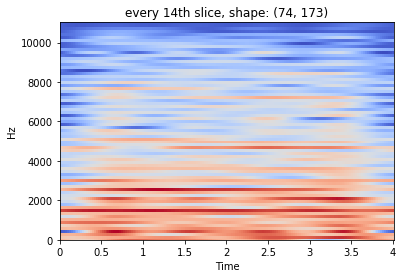

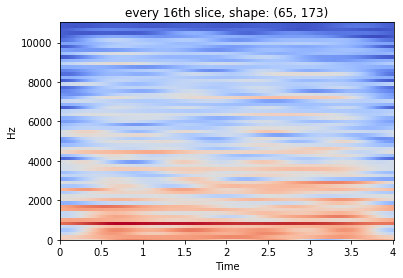

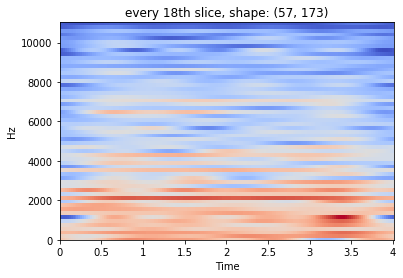

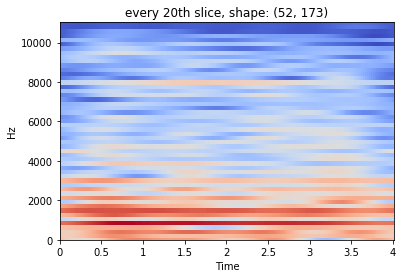

In [272]:
#  Now that I have the correct timeslice length, 
#  I decimate frequency bands at different factors and render.  For this sound, I've effectively added
#  added rows to the X axis, and now I will subtract rows from the Y axis.
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = upsampled_horn[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2

# Librosa has a time stretching function.  That's awesome!

In [251]:
#data, rate = librosa.load(train_files[12])
##ata, rate = librosa.load(train_files[15])
data, rate = librosa.load(horn_file)
ipd.Audio(data, rate=rate)

print(data.shape)

target_len = 88200

print(data.shape[0]/target_len)

stretched = librosa.effects.time_stretch(data, rate=data.shape[0]/target_len)
stretched = stretched[:target_len:]
stretched.shape

(4574,)
0.051859410430839005


(88200,)

In [252]:
ipd.Audio(data, rate=rate)

In [253]:
ipd.Audio(stretched, rate=rate)


In [254]:
st = data_to_spec(stretched)

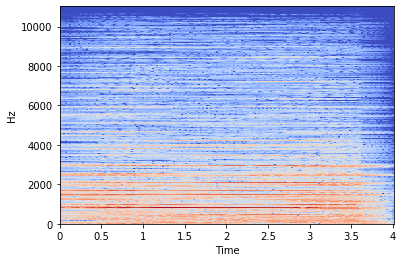

In [255]:
librosa.display.specshow(st, x_axis='time', y_axis='linear');

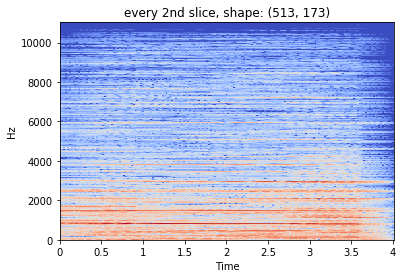

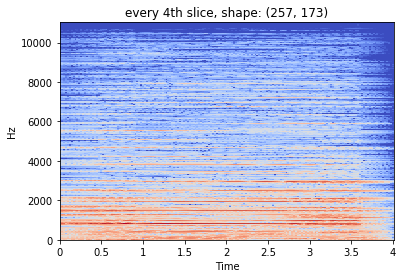

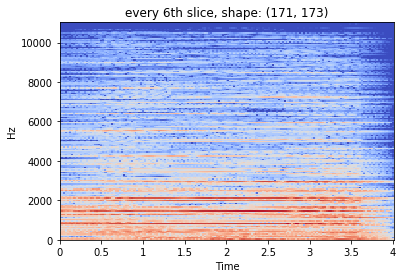

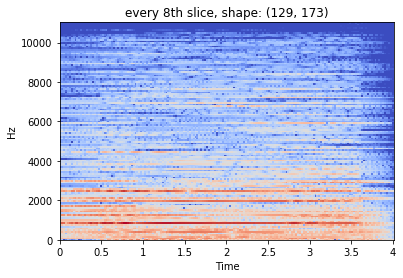

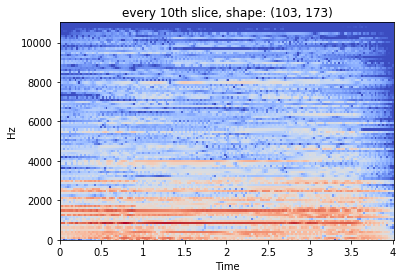

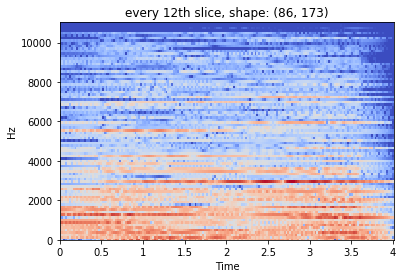

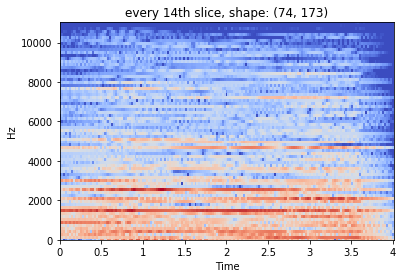

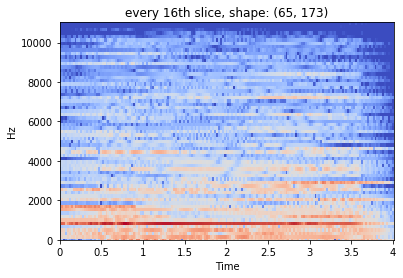

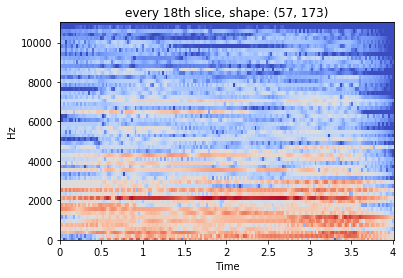

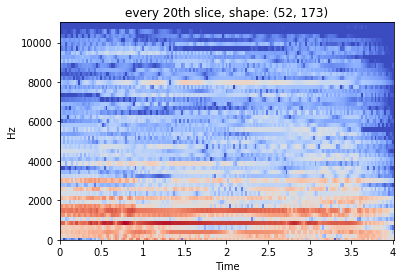

In [256]:
#  To be complete, decimate again
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = st[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2